In [ ]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')
os.chdir('/content')


Mounted at /content/drive


In [ ]:
!git clone https://github.com/tim-pan/pytorch-nested-unet

Cloning into 'pytorch-nested-unet'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 119 (delta 24), reused 0 (delta 0), pack-reused 77
Receiving objects: 100% (119/119), 41.84 KiB | 1.16 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
%cd pytorch-nested-unet
!pip install -r requirements.txt

from google_drive_downloader import GoogleDriveDownloader as gdd
import os
import re
import shutil
#load dataset
gdd.download_file_from_google_drive(file_id='1nEJ7NTtHcCHNQqUXaoPk55VH3Uwh4QGG',
                                    dest_path='./inputs/dataset.zip',
                                    unzip=True)

/content/pytorch-nested-unet
     |████████████████████████████████| 631 kB 4.0 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=0cd5031daf4fe529be4b6902f0b9f703f70c0db7fb0a3afe6861620e2557504e
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Unzipping...Done.


In [ ]:
!python preprocess_dsb2018.py

100% 24/24 [01:18<00:00,  3.25s/it]


In [ ]:
# !python train.py --dataset dsb2018 --arch NestedUNet

--------------------
name: dsb2018_NestedUNet_woDS
epochs: 100
batch_size: 16
arch: NestedUNet
deep_supervision: False
input_channels: 3
num_classes: 1
input_w: 256
input_h: 256
loss: BCEDiceLoss
dataset: dsb2018
img_ext: .png
mask_ext: .png
optimizer: SGD
lr: 0.001
momentum: 0.9
weight_decay: 0.0001
nesterov: False
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
num_workers: 4
--------------------
=> creating model NestedUNet
['TCGA-NH-A8F7-01A-01-TS1', 'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-RD-A8N9-01A-01-TS1', 'TCGA-49-4488-01Z-00-DX1', 'TCGA-21-5786-01Z-00-DX1', 'TCGA-18-5592-01Z-00-DX1', 'TCGA-HE-7128-01Z-00-DX1', 'TCGA-G9-6362-01Z-00-DX1', 'TCGA-21-5784-01Z-00-DX1', 'TCGA-E2-A14V-01Z-00-DX1', 'TCGA-38-6178-01Z-00-DX1', 'TCGA-G9-6363-01Z-00-DX1', 'TCGA-B0-5711-01Z-00-DX1', 'TCGA-HE-7130-01Z-00-DX1', 'TCGA-HE-7129-01Z-00-DX1', 'TCGA-AR-A1AK-01Z-00-DX1', 'TCGA-G9-6356-01Z-00-DX1', 'TCGA-CH-5767-01Z-00-DX1', 'T

In [ ]:
from shutil import copyfile
copyfile('/content/pytorch-nested-unet/models/dsb2018_NestedUNet_woDS/model.pth', '/content/drive/MyDrive/VRDL/hw3_unet/json_files/unet1.pth')


'/content/drive/MyDrive/VRDL/hw3_unet/json_files/unet1.pth'

In [ ]:
import argparse
import os
from glob import glob

import cv2
import torch
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import yaml
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import archs
from dataset import Dataset
from metrics import iou_score
from utils import AverageMeter


# def parse_args():
#     parser = argparse.ArgumentParser()

#     parser.add_argument('--name', default=None,
#                         help='model name')

#     args = parser.parse_args()

#     return args
import cv2
import os
import numpy as np
import torch
import torch.utils.data
import glob
import json
import torchvision.transforms as transforms
from PIL import Image
# from albumentations.augmentations import transforms
# from albumentations.core.composition import Compose



class nuclei_test(torch.utils.data.Dataset):
    def __init__(self, img_dir, num_classes=1, transform=None):
        # self.img_ids = img_ids
        self.img_dir = img_dir
        self.num_classes = num_classes
        self.transform = transform
        self.filenames = os.listdir(self.img_dir)
        with open('./inputs/dataset/test_img_ids.json', 'r') as fp:
            self.img_json = json.load(fp)
    def __len__(self):
        return 6

    def __getitem__(self, idx):
        self.img_dict = self.img_json[idx]
        img_id = self.img_dict['id']
        img_name = self.img_dict['file_name']
        img = Image.open(os.path.join(self.img_dir, img_name))
    
        if self.transform is not None:
            img = self.transform(img)
        
        # img = img.astype('float32') / 255
        # img = img.transpose(2, 0, 1)
        
        return img, img_id,  img_name




def val(MODEL_PATH, img_size, BS, deep_supervision=False):
    # args = parse_args()

    # with open('models/%s/config.yml' % args.name, 'r') as f:
    #     config = yaml.load(f, Loader=yaml.FullLoader)

    # print('-'*20)
    # for key in config.keys():
    #     print('%s: %s' % (key, str(config[key])))
    # print('-'*20)

    cudnn.benchmark = True

    # create model
    model = archs.__dict__['NestedUNet'](1, 3, deep_supervision)

    model = model.cuda()

    # Data loading code
    # img_ids = glob(os.path.join('inputs', 'dataset', 'test', '*' + '.png'))
    # img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

    # _, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)

    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5), (0.5))
    ])

    val_dataset = nuclei_test(
        './inputs/dataset/test', 
        num_classes=1, 
        transform=val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=BS,
        shuffle=False,
        num_workers=4,
        drop_last=False)

    # avg_meter = AverageMeter()

    for c in range(1):
        os.makedirs(os.path.join('outputs', 'dsb2018_NestedUNet_woDS', str(c)), exist_ok=True)
    with torch.no_grad():
        for input, img_id, img_name in tqdm(val_loader):
            input = input.cuda()
            # target = target.cuda()

            # compute output
            if deep_supervision:
                output = model(input)[-1]
            else:
                output = model(input)

            # iou = iou_score(output, target)
            # avg_meter.update(iou, input.size(0))
            output = torch.squeeze(output, 1)
            output = output.cpu().numpy()
            print(output.shape)
            # output = torch.sigmoid(output).cpu().numpy()
            
            # for i in range(len(output)):
            #     for c in range(1):
            #         cv2.imwrite(os.path.join('outputs', 'dsb2018_NestedUNet_woDS', i + '.png'),
            #                     (output[i, c] * 255).astype('uint8'))


            #####################################modify#####################################
            for_poly = output.copy()
            plt.imshow(np.transpose(for_poly, (1, 2, 0)))
            # contours is a  tuple record all points of polygon
            # contours, _ = cv2.findContours(for_output, cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) 
            

    # print('IoU: %.4f' % avg_meter.avg)

    torch.cuda.empty_cache()





/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 50%|█████     | 1/2 [00:00<00:00,  1.60it/s]

(3, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

(3, 256, 256)


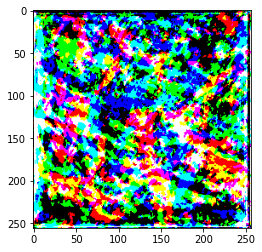

In [ ]:
val('/content/drive/MyDrive/VRDL/hw3_unet/json_files/unet1.pth', 256, 3, deep_supervision=False)
